In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from datetime import datetime, timedelta
import os

%matplotlib notebook

In [13]:
import pprint
pp = pprint.PrettyPrinter(indent=4)

In [14]:
from bs4 import BeautifulSoup

In [15]:
# directory = 'outbound'
directory = 'return'

In [16]:
### Main Processsing Code


main_origins = set()
main_destinations = set()


df = pd.DataFrame()

## Loop over HTML files, convert to DataFrame
for fn in os.listdir(directory):
    if fn[-5:] == '.html':
        # print(fn)
        
        fullpath = os.path.join(directory, fn)
        
        columns = ['Select', 'Flight', 'From', 'To', 'Departure Date', 'Departure Time', 'Arrival Date', 'Arrival Time', 
                  'Aircraft', 'Delta One', 'First Class', 'Premium Select', 'Comfort+', 'Main Cabin',
                  'Total_Avail','B']
        
        df = df.append(pd.read_html(fullpath, attrs={'id': 'flightsOut'})[0], ignore_index=True)

        
        # Get Origin / Destination from HTML
        with open(fullpath, 'rb') as html:
            soup = BeautifulSoup(html, 'lxml')

            origin = soup.find(id="fromAirport").get_attribute_list('value')[0]
            destination = soup.find(id="toAirport").get_attribute_list('value')[0]
            
            
            main_origins.add(origin)
            main_destinations.add(destination)

# print(df.head())

# for c in df.columns:
#     print(c)
    
# Rename columns            
df.columns = columns

# print('Origins:', main_origins)
# print('Destinations:', main_destinations)


## Parse Raw DataFrame
parsed_df = df[['From', 'To', 'Aircraft']].copy()


k = 0
for n, row in df.iterrows():
    
    # Group flights by route
    if row['From'] in main_origins:
        k += 1
    
    parsed_df.loc[n, 'Group'] = k
#     parsed_df.loc[n, 'flight_num'] = row['Flight'].split()[0]
    parsed_df.loc[n, 'flight_num'] = int(''.join(c for c in str(row['Flight']) if c.isdigit()))
    
    
    # Combine departure date/time
    datetime_object = datetime.strptime('{} 2017 {}'.format(row['Departure Date'], row['Departure Time']), '%d%b %Y %I:%M%p')
    parsed_df.loc[n, 'dep_datetime'] = datetime_object
    
    # Combine Arrival date/time
    datetime_object = datetime.strptime('{} 2017 {}'.format(row['Arrival Date'], row['Arrival Time']), '%d%b %Y %I:%M%p')
    parsed_df.loc[n, 'arr_datetime'] = datetime_object
    
    # Combine total available seats
    total_seats = {'av': 0, 'au':0, 'cap':0}
    
#     for label, col in zip(['business', 'first', 'main'], ['BusinessAv/Au(Cap)', 'First ClassAv/Au(Cap)', 'Main CabinAv/Au(Cap)']):
    for label, col in zip(['one', 'first', 'select', 'comfort', 'main'], ['Delta One', 'First Class', 'Premium Select', 'Comfort+', 'Main Cabin']):
        if '/' in row[col]:
            av, temp = row[col].split('/')
            au, temp2 = temp.split('(')
            cap = temp2.replace(')', '')

            seats = {'av': int(av), 'au':int(au), 'cap':int(cap)}

            for key in ['av', 'au', 'cap']:
                total_seats[key] = total_seats[key] + seats[key]

    for key in ['av', 'au', 'cap']:
        parsed_df.loc[n, 'total_{}'.format(key)] = total_seats[key]


## Remove routes with more than one layover
single_stop_df = pd.DataFrame()

for n, group in parsed_df.groupby('Group'):
    if group.shape[0] <= 2:
        single_stop_df = single_stop_df.append(group)
        
parsed_df = single_stop_df


## Create set of layover options
origins = set({})
destinations = set({})
layovers = set([])

for r, row in parsed_df.iterrows():
    origins.add(row.From)
    destinations.add(row.To)
    
    if row.From in main_origins:
        layovers.add(row.To)
    
    if row.To in main_destinations:
        layovers.add(row.From)
        
# print(origins, destinations, layovers)


## Reduce dataframe to only unique flights
dedup_df = parsed_df.drop_duplicates('flight_num')

In [17]:
df.head()

,Select,Flight,From,To,Departure Date,Departure Time,Arrival Date,Arrival Time,Aircraft,Delta One,First Class,Premium Select,Comfort+,Main Cabin,Total_Avail,B
0,NaN,DL 1868,AUS,ATL,12May,10:30AM,12May,01:34PM,321,-,3/3(20),-,0/0(27),17/20(145),20,NaN
1,NaN,DL 1534,ATL,IND,12May,02:39PM,12May,04:07PM,M88,-,3/3(16),-,10/10(23),16/30(110),29,NaN
2,NaN,DL 2402,AUS,ATL,12May,03:10PM,12May,06:20PM,321,-,3/3(20),-,13/13(27),8/24(145),24,NaN
3,NaN,DL 1261,ATL,IND,12May,07:26PM,12May,08:55PM,739,-,1/1(20),-,4/4(19),4/16(141),9,NaN
4,NaN,DL 2622,AUS,MSP,12May,04:00PM,12May,06:45PM,717,-,1/1(12),-,10/10(18),8/19(80),19,NaN


In [18]:
def find_first_last(all_flights, selected_origins, selected_layovers, selected_destinations):
    first_flights = pd.DataFrame()

    for n, flight in all_flights.iterrows():
        if flight.From in selected_origins and flight.To in selected_layovers:
            first_flights = first_flights.append(flight, ignore_index=True)

    if first_flights.shape[0] > 0:
        first_flights = first_flights.sort_values('dep_datetime')

    last_flights = pd.DataFrame()

    for n, flight in all_flights.iterrows():
        if flight.From in selected_layovers and flight.To in selected_destinations:
            last_flights = last_flights.append(flight, ignore_index=True)

    if last_flights.shape[0] > 0:
        last_flights = last_flights.sort_values('arr_datetime')
    
    return first_flights, last_flights

def plot_flight(flight, line_count, ax, c='c'):
    
    plt.plot([flight.dep_datetime, flight.arr_datetime], [line_count, line_count], '-', c=c, linewidth=max(1,flight.total_av/2), solid_capstyle='butt')
    
    dep_str = '{} {}'.format(flight.dep_datetime.strftime('%I:%M%p'), flight.From)
    arr_str = '{} {}'.format(flight.To, flight.arr_datetime.strftime('%I:%M%p'))
    
    t = ax.text(flight.dep_datetime, line_count, dep_str+'->'+arr_str, ha="left", va="bottom")
    #     t = ax.text(flight.arr_datetime, line_count, arr_str, ha="center", va="bottom")
    
    desc_str = 'FN: {}, Av: {}'.format(int(flight.flight_num), flight.total_av)
    t = ax.text(flight.arr_datetime, line_count, desc_str, ha="right", va="top")

In [19]:
def plot_origin(all_flights, first_flights, selected_destinations, fig=None):
    ### Origin Flights first
    if fig is None:
        fig = plt.figure()
    else:
        fig.clf()

    ax = plt.gca()

    myFmt = mdates.DateFormatter('%m-%d %I:%M%p')
    ax.xaxis.set_major_formatter(myFmt)
    labels = ax.get_xticklabels()
    plt.setp(labels, rotation=30, fontsize=8)
    


    line_count = 1
    for n, flight in first_flights.iterrows():
        
        conn_flights = []

        connections = all_flights[all_flights.From == flight.To]
        connections = connections[connections.dep_datetime >= flight.arr_datetime + timedelta(minutes=25)].sort_values('dep_datetime')

        for n, conn_flight in connections.iterrows():            
            if conn_flight.To in selected_destinations:
                conn_flights.append(conn_flight)
                
        
        if len(conn_flights) > 0:
                
            plot_flight(flight, line_count, ax)
            line_count += 1
            
            for conn_flight in conn_flights:
                plot_flight(conn_flight, line_count, ax, c='y')
                line_count += 1

    fig.set_size_inches(13, line_count*0.4+1)

    plt.grid()

    ax2 = ax.twiny()
    ax2.set_xlim(ax.get_xlim())
    ax2.xaxis.set_major_formatter(myFmt)
    ax2.xaxis.set_ticks(ax.get_xticks())
    labels = ax2.get_xticklabels()
    plt.setp(labels, rotation=30, fontsize=8)

    try:
        plt.tight_layout()
    except ValueError:
        pass
    
    plt.ylim([line_count,0])
    

def plot_destination(all_flights, last_flights, selected_origins, fig=None):
    ### Destination Flights first
   
    if fig is None:
        fig = plt.figure()
    else:
        fig.clf()

    ax = plt.gca()

    myFmt = mdates.DateFormatter('%m-%d %I:%M%p')
    ax.xaxis.set_major_formatter(myFmt)
    labels = ax.get_xticklabels()
    plt.setp(labels, rotation=30, fontsize=12)

    line_count = 1
    k=0

    for n, flight in last_flights.iterrows():
        
        connection_found=False

        connections = all_flights[all_flights.To == flight.From]
        connections = connections[connections.arr_datetime <= flight.dep_datetime - timedelta(minutes=25)].sort_values('dep_datetime')

        for n, conn_flight in connections.iterrows():

            if conn_flight.From in selected_origins:
                plot_flight(conn_flight, line_count, ax, c='c')

                line_count += 1
                connection_found = True

        if connection_found:

            plot_flight(flight, line_count, ax, c='y')
            line_count += 1

    fig.set_size_inches(13, line_count*0.4+1)
    plt.grid()
    
    ax2 = ax.twiny()
    ax2.set_xlim(ax.get_xlim())
    ax2.xaxis.set_major_formatter(myFmt)
    ax2.xaxis.set_ticks(ax.get_xticks())
    labels = ax2.get_xticklabels()
    plt.setp(labels, rotation=30, fontsize=8)
    
    try:
        plt.tight_layout()
    except ValueError:
        pass

    plt.ylim([line_count,0])

In [20]:
def make_date_sliders(start,end,freq='D',fmt='%Y-%m-%d', disp_fmt='%Y-%m-%d'):
        """
        Parameters
        ----------
        start : string or datetime-like
            Left bound of the period
        end : string or datetime-like
            Left bound of the period
        freq : string or pandas.DateOffset, default='D'
            Frequency strings can have multiples, e.g. '5H' 
        fmt : string, defauly = '%Y-%m-%d'
            Format to use to display the selected period

        """
        date_range=pd.date_range(start=start,end=end,freq=freq)
        
        options = [(item.strftime(disp_fmt),item) for item in date_range]
        
        slider_start = widgets.SelectionSlider(
            description='start',
            options=options,
            continuous_update=False,
            layout=widgets.Layout(width='600px')
        )
        
        slider_end = widgets.SelectionSlider(
            description='end',
            options=options,
            continuous_update=False,
            value=options[-1][1],
            layout=widgets.Layout(width='600px')
        )
        return slider_start, slider_end

In [21]:
dedup_df

,From,To,Aircraft,Group,flight_num,dep_datetime,arr_datetime,total_av,total_au,total_cap
0,AUS,ATL,321,1.0,1868.0,2017-05-12 10:30:00,2017-05-12 13:34:00,20.0,23.0,192.0
1,ATL,IND,M88,1.0,1534.0,2017-05-12 14:39:00,2017-05-12 16:07:00,29.0,43.0,149.0
2,AUS,ATL,321,2.0,2402.0,2017-05-12 15:10:00,2017-05-12 18:20:00,24.0,40.0,192.0
3,ATL,IND,739,2.0,1261.0,2017-05-12 19:26:00,2017-05-12 20:55:00,9.0,21.0,180.0
4,AUS,MSP,717,3.0,2622.0,2017-05-12 16:00:00,2017-05-12 18:45:00,19.0,30.0,110.0
5,MSP,IND,CR9,3.0,5200.0,2017-05-12 19:30:00,2017-05-12 22:11:00,24.0,45.0,76.0
6,AUS,DTW,319,4.0,1822.0,2017-05-12 06:55:00,2017-05-12 10:45:00,13.0,16.0,132.0
7,DTW,IND,CR7,4.0,6237.0,2017-05-12 12:22:00,2017-05-12 13:31:00,13.0,23.0,69.0
8,AUS,MSP,319,5.0,2447.0,2017-05-12 07:30:00,2017-05-12 10:10:00,38.0,48.0,132.0
9,MSP,IND,CR9,5.0,3361.0,2017-05-12 11:31:00,2017-05-12 14:09:00,20.0,42.0,76.0


<IPython.core.display.Javascript object>


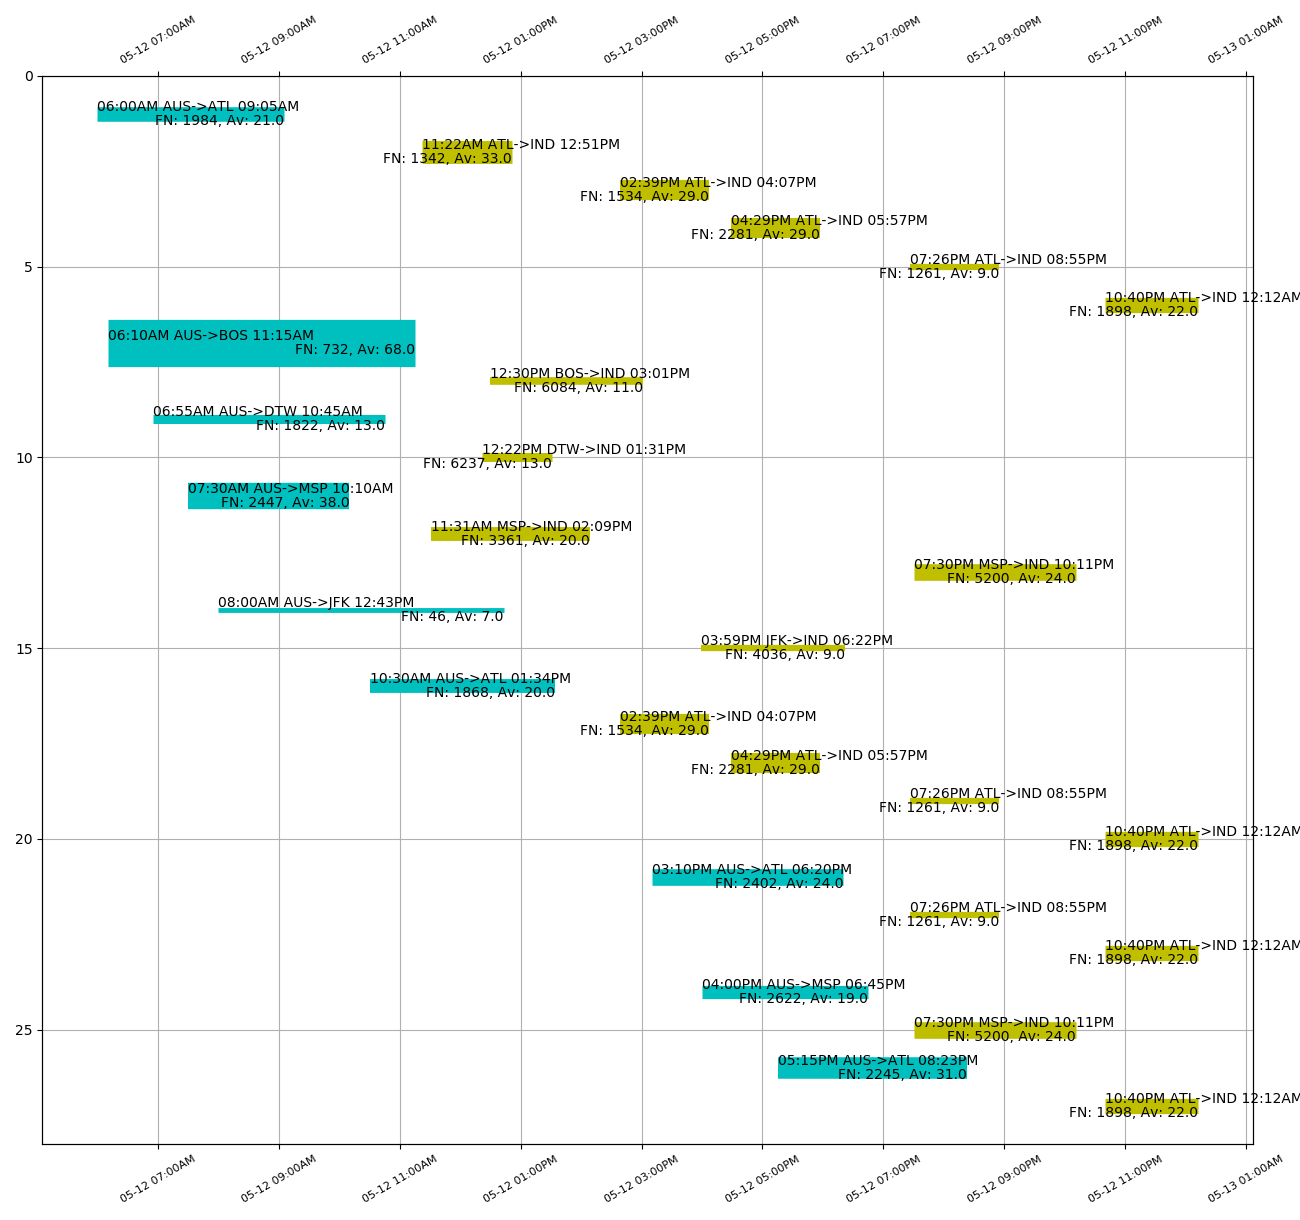

A Jupyter Widget

In [22]:
## Build Dashboard
import ipywidgets as widgets

origin_select = widgets.SelectMultiple(
    options=list(main_origins),
    value=list(main_origins),
    description='Origins:',
    disabled=False,
)

destination_select = widgets.SelectMultiple(
    options=list(main_destinations),
    value=list(main_destinations),
    description='Destinations:',
    disabled=False,
)

layover_select = widgets.SelectMultiple(
    options=list(layovers),
    value=list(layovers),
    description='Layovers:',
    disabled=False,
)

plot_radio = widgets.RadioButtons(
    options=['Origin First', 'Destination First'],
    value='Origin First',
    description='Plot Order:',
    disabled=False
)

slider_availability = widgets.SelectionSlider(
    description='avail',
#     options=list(range(int(dedup_df.total_av.min()),20)),
    options=list(range(0,20)),
    value=0,
    continuous_update=False,
    layout=widgets.Layout(width='600px')
)
        


## Date sliders
fmt='%Y-%m-%d %I:%M%p'

start_date = datetime.strftime(dedup_df.dep_datetime.min() - timedelta(hours=1), fmt)
end_date = datetime.strftime(dedup_df.arr_datetime.max() + timedelta(hours=1), fmt)

slider_start, slider_end = make_date_sliders(start=start_date, end=end_date, freq=timedelta(minutes=30),fmt=fmt, disp_fmt='%m-%d %I:%M%p')


fig = plt.figure()

def change_states(change):
    
    # pp.pprint(change)
    if change['name'] == 'value':
        
        selected_origins = origin_select.value
        selected_layovers = layover_select.value
        selected_destinations = destination_select.value
        
        all_flights = dedup_df[dedup_df.dep_datetime > slider_start.value]
        all_flights = all_flights[all_flights.arr_datetime < slider_end.value]
        all_flights = all_flights[all_flights.total_av >= slider_availability.value]
                
        first_flights, last_flights = find_first_last(all_flights, selected_origins, selected_layovers, selected_destinations)
        
        if plot_radio.value == 'Origin First':
            if first_flights.shape[0] > 0:
                plot_origin(all_flights, first_flights, selected_destinations, fig=fig)
            else:
                fig.clf()
        else:
            if last_flights.shape[0] > 0:
                plot_destination(all_flights, last_flights, selected_origins, fig=fig)
            else:
                fig.clf()


origin_select.observe(change_states)
layover_select.observe(change_states)
destination_select.observe(change_states)
plot_radio.observe(change_states)
slider_start.observe(change_states)
slider_end.observe(change_states)
slider_availability.observe(change_states)

change_states({'name': 'value'})


items = [plot_radio, origin_select, layover_select, destination_select]
widgets.VBox([widgets.HBox([slider_start, slider_end]), slider_availability, widgets.HBox(items)])

